## Logic Based FizzBuzz Function [Software 1.0]

In [1]:
#pandas is a Python package providing fast, flexible, and expressive data structures designed to make working with “relational” or “labeled” data both easy and intuitive. 
import pandas as pd

def fizzbuzz(n):
    
    # Logic Explanation
    if n % 3 == 0 and n % 5 == 0:
        return 'FizzBuzz'
    elif n % 3 == 0:
        return 'Fizz'
    elif n % 5 == 0:
        return 'Buzz'
    else:
        return 'Other'

## Create Training and Testing Datasets in CSV Format

In [2]:
def createInputCSV(start,end,filename):
    
    # List is a collection(datasets) which is ordered and changeable and allows duplicate values.
    inputData   = []
    outputData  = []
    
    # Training data is used by ML Algorithm in training the model.
    for i in range(start,end):
        inputData.append(i)
        outputData.append(fizzbuzz(i))
    
    # DataFrame is a 2-dimensional labeled data structure with columns of potentially different types
    # we have two labels;one for input (number) and other for label (fizzbuzz values)
    dataset = {}
    dataset["input"]  = inputData
    dataset["label"] = outputData
    
    # Writing to csv
    pd.DataFrame(dataset).to_csv(filename)
    
    print(filename, "Created!")

## Processing Input and Label Data

In [3]:
# Cannot operate on label data directly so input variables and output variables have to be numeric.
def processData(dataset):
       
    data   = dataset['input'].values
    labels = dataset['label'].values
    
    processedData  = encodeData(data)
    processedLabel = encodeLabel(labels)
    
    return processedData, processedLabel

In [4]:
 # To Convert the input to vector of activations 
def encodeData(data):
    
    processedData = []
     # The training data set ranges from 101 to 1000 which needs atmost 10 binary digits to represent the values.
    # Creates a list containing the last bit of datainstance after it got shifted d times to the right and bitwise AND with 01.
    for dataInstance in data:    
        processedData.append([dataInstance >> d & 1 for d in range(10)])
     
    
    return np.array(processedData)

## Model Definition

In [5]:
from keras.utils import np_utils
# One-hot encoding to convert label data to integers
def encodeLabel(labels):
    
    processedLabel = []
    
    for labelInstance in labels:
        if(labelInstance == "FizzBuzz"):
            # Fizzbuzz
            processedLabel.append([3])
        elif(labelInstance == "Fizz"):
            # Fizz
            processedLabel.append([1])
        elif(labelInstance == "Buzz"):
            # Buzz
            processedLabel.append([2])
        else:
            # Other
            processedLabel.append([0])
    #Converts a class vector (integers) to binary class matrix.
    return np_utils.to_categorical(np.array(processedLabel),4)

Using TensorFlow backend.


In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard

import numpy as np

input_size = 10
drop_out = 0.1
first_dense_layer_nodes  = 512
second_dense_layer_nodes = 4

def get_model():
    
    # We need a model to train the dataset.To build it on stack of layers with simplicity,we use sequential model.   
    model = Sequential()    
   
    # Dense layer acts as hidden layer/output layer in model creation.
    # Activation is used to provide non linearity to the model and must be differentiable for backpropagation.
    #The input_dim specifies the shape of the input the model should expect,using bias
    model.add(Dense(first_dense_layer_nodes, use_bias=True,input_dim=input_size))
    
    #'relu' as ativation function to minimise vanishing gradient problem
    model.add(Activation('relu'))
    
    # drop out to avoid overfitting of models by randomly dropping few neurons
    model.add(Dropout(drop_out))
    
    # Output layer
    model.add(Dense(second_dense_layer_nodes))
    
    # Used in multiple classification logistic regression model.
    # Softmax function is returns the probabilities of each class where target class has the highest probability.
    model.add(Activation('softmax'))
    
    # prints a summary representation of the model
    model.summary()
    
    # configuring the learning process to train the model
    # multi class classification problem, we use categorical_crossentropy as loss function
    # We judge the performance of your model by recoding the Metric values at the end of each epoch on the training dataset
    model.compile(optimizer='adadelta',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
   
    return model

# <font color='blue'>Creating Training and Testing Datafiles</font>

In [7]:
# Create datafiles
createInputCSV(101,1001,'training.csv')
createInputCSV(1,101,'testing.csv')

training.csv Created!
testing.csv Created!


# <font color='blue'>Creating Model</font>

In [8]:
#(10 input values + one bias ) * number of nodes= 11*512
# (no of nodes in the hidden layer+ one bias) * no of output nodes = 513*4 
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               5632      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total params: 7,684
Trainable params: 7,684
Non-trainable params: 0
_________________________________________________________________


# <font color = blue>Run Model</font>

In [9]:
from keras.callbacks import ModelCheckpoint

# evaluate the performance of the model on the validation dataset a end of each epoch.
# 20% of the training data is held back for validation
validation_data_split = 0.1

# number of passes over the entire dataset
num_epochs = 1500

# number of samples propagated for one pass at a time
model_batch_size = 128

#size of batch of inputs to feed to the network for histograms computation.
tb_batch_size = 32

#number of epochs with no improvement after which training will be stopped.
early_patience = 150

#TensorBoard is a visualization tool provided with TensorFlow
#This callback writes a log for TensorBoard, which allows you to visualize dynamic graphs of your training and test metrics, as well as activation histograms for the different layers in your model.
tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)


#min mode-training will stop when the quantity monitored has stopped decreasing
filepath="weights.txt" 
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#Stop training when a monitored quantity has stopped improving.
earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

# Read Dataset
dataset = pd.read_csv('training.csv')

# Process Dataset
processedData, processedLabel = processData(dataset)

#Trains the model for a given number of epochs 
history = model.fit(processedData
                    , processedLabel
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )

Train on 810 samples, validate on 90 samples
Epoch 1/1500
810/810 [==============================] - 0s 297us/step - loss: 1.2970 - acc: 0.4494 - val_loss: 1.1676 - val_acc: 0.5333
Epoch 2/1500
810/810 [==============================] - 0s 31us/step - loss: 1.1755 - acc: 0.5333 - val_loss: 1.1423 - val_acc: 0.5333
Epoch 3/1500
810/810 [==============================] - 0s 28us/step - loss: 1.1535 - acc: 0.5333 - val_loss: 1.1474 - val_acc: 0.5333
Epoch 4/1500
810/810 [==============================] - 0s 39us/step - loss: 1.1494 - acc: 0.5333 - val_loss: 1.1505 - val_acc: 0.5333
Epoch 5/1500
810/810 [==============================] - 0s 19us/step - loss: 1.1472 - acc: 0.5333 - val_loss: 1.1562 - val_acc: 0.5333
Epoch 6/1500
810/810 [==============================] - 0s 28us/step - loss: 1.1510 - acc: 0.5333 - val_loss: 1.1542 - val_acc: 0.5333
Epoch 7/1500
810/810 [==============================] - 0s 19us/step - loss: 1.1428 - acc: 0.5333 - val_loss: 1.1646 - val_acc: 0.5333
Epoch 8/1

Epoch 61/1500
810/810 [==============================] - 0s 38us/step - loss: 1.0019 - acc: 0.5617 - val_loss: 1.0832 - val_acc: 0.5444
Epoch 62/1500
810/810 [==============================] - 0s 38us/step - loss: 0.9962 - acc: 0.5630 - val_loss: 1.0737 - val_acc: 0.5333
Epoch 63/1500
810/810 [==============================] - 0s 31us/step - loss: 0.9909 - acc: 0.5630 - val_loss: 1.0730 - val_acc: 0.5444
Epoch 64/1500
810/810 [==============================] - 0s 39us/step - loss: 0.9919 - acc: 0.5790 - val_loss: 1.0672 - val_acc: 0.5333
Epoch 65/1500
810/810 [==============================] - 0s 39us/step - loss: 0.9829 - acc: 0.5778 - val_loss: 1.0699 - val_acc: 0.5333
Epoch 66/1500
810/810 [==============================] - 0s 42us/step - loss: 0.9806 - acc: 0.5840 - val_loss: 1.0714 - val_acc: 0.5333
Epoch 67/1500
810/810 [==============================] - 0s 33us/step - loss: 0.9811 - acc: 0.5580 - val_loss: 1.0659 - val_acc: 0.5333
Epoch 68/1500
810/810 [=========================

Epoch 121/1500
810/810 [==============================] - 0s 32us/step - loss: 0.7149 - acc: 0.7407 - val_loss: 0.9035 - val_acc: 0.5333
Epoch 122/1500
810/810 [==============================] - 0s 33us/step - loss: 0.7073 - acc: 0.7494 - val_loss: 0.8748 - val_acc: 0.5778
Epoch 123/1500
810/810 [==============================] - 0s 34us/step - loss: 0.7117 - acc: 0.7605 - val_loss: 0.8722 - val_acc: 0.5778
Epoch 124/1500
810/810 [==============================] - 0s 37us/step - loss: 0.6951 - acc: 0.7642 - val_loss: 0.8734 - val_acc: 0.5667
Epoch 125/1500
810/810 [==============================] - 0s 58us/step - loss: 0.6960 - acc: 0.7556 - val_loss: 0.8547 - val_acc: 0.6778
Epoch 126/1500
810/810 [==============================] - 0s 38us/step - loss: 0.6835 - acc: 0.7765 - val_loss: 0.9515 - val_acc: 0.5333
Epoch 127/1500
810/810 [==============================] - 0s 34us/step - loss: 0.6907 - acc: 0.7543 - val_loss: 0.8618 - val_acc: 0.6000
Epoch 128/1500
810/810 [=================

810/810 [==============================] - 0s 33us/step - loss: 0.5104 - acc: 0.8519 - val_loss: 0.7800 - val_acc: 0.5778
Epoch 181/1500
810/810 [==============================] - 0s 31us/step - loss: 0.4797 - acc: 0.8593 - val_loss: 0.7136 - val_acc: 0.6444
Epoch 182/1500
810/810 [==============================] - 0s 30us/step - loss: 0.4932 - acc: 0.8617 - val_loss: 0.6894 - val_acc: 0.6667
Epoch 183/1500
810/810 [==============================] - 0s 32us/step - loss: 0.4737 - acc: 0.8877 - val_loss: 0.7176 - val_acc: 0.6333
Epoch 184/1500
810/810 [==============================] - 0s 34us/step - loss: 0.4739 - acc: 0.8765 - val_loss: 0.6735 - val_acc: 0.7222
Epoch 185/1500
810/810 [==============================] - 0s 31us/step - loss: 0.4917 - acc: 0.8765 - val_loss: 0.7503 - val_acc: 0.6111
Epoch 186/1500
810/810 [==============================] - 0s 36us/step - loss: 0.4906 - acc: 0.8654 - val_loss: 0.7183 - val_acc: 0.6222
Epoch 187/1500
810/810 [==============================] 

Epoch 240/1500
810/810 [==============================] - 0s 32us/step - loss: 0.3455 - acc: 0.9309 - val_loss: 0.5652 - val_acc: 0.8222
Epoch 241/1500
810/810 [==============================] - 0s 31us/step - loss: 0.3565 - acc: 0.9272 - val_loss: 0.5490 - val_acc: 0.8444
Epoch 242/1500
810/810 [==============================] - 0s 32us/step - loss: 0.3588 - acc: 0.9185 - val_loss: 0.5735 - val_acc: 0.7333
Epoch 243/1500
810/810 [==============================] - 0s 32us/step - loss: 0.3558 - acc: 0.9296 - val_loss: 0.6007 - val_acc: 0.7222
Epoch 244/1500
810/810 [==============================] - 0s 33us/step - loss: 0.3534 - acc: 0.9173 - val_loss: 0.6185 - val_acc: 0.6444
Epoch 245/1500
810/810 [==============================] - 0s 37us/step - loss: 0.3541 - acc: 0.9123 - val_loss: 0.5438 - val_acc: 0.8556
Epoch 246/1500
810/810 [==============================] - 0s 31us/step - loss: 0.3499 - acc: 0.9173 - val_loss: 0.6387 - val_acc: 0.6556
Epoch 247/1500
810/810 [=================

810/810 [==============================] - 0s 42us/step - loss: 0.2803 - acc: 0.9432 - val_loss: 0.5339 - val_acc: 0.7333
Epoch 300/1500
810/810 [==============================] - 0s 30us/step - loss: 0.2573 - acc: 0.9556 - val_loss: 0.5466 - val_acc: 0.7222
Epoch 301/1500
810/810 [==============================] - 0s 31us/step - loss: 0.2620 - acc: 0.9593 - val_loss: 0.4605 - val_acc: 0.8222
Epoch 302/1500
810/810 [==============================] - 0s 49us/step - loss: 0.2670 - acc: 0.9444 - val_loss: 0.4957 - val_acc: 0.7889
Epoch 303/1500
810/810 [==============================] - 0s 39us/step - loss: 0.2582 - acc: 0.9605 - val_loss: 0.4941 - val_acc: 0.8000
Epoch 304/1500
810/810 [==============================] - 0s 31us/step - loss: 0.2536 - acc: 0.9494 - val_loss: 0.5047 - val_acc: 0.8000
Epoch 305/1500
810/810 [==============================] - 0s 38us/step - loss: 0.2547 - acc: 0.9556 - val_loss: 0.4491 - val_acc: 0.9000
Epoch 306/1500
810/810 [==============================] 

Epoch 359/1500
810/810 [==============================] - 0s 26us/step - loss: 0.2086 - acc: 0.9630 - val_loss: 0.3905 - val_acc: 0.8556
Epoch 360/1500
810/810 [==============================] - 0s 19us/step - loss: 0.2128 - acc: 0.9605 - val_loss: 0.4549 - val_acc: 0.7778
Epoch 361/1500
810/810 [==============================] - 0s 39us/step - loss: 0.2024 - acc: 0.9593 - val_loss: 0.4219 - val_acc: 0.8222
Epoch 362/1500
810/810 [==============================] - 0s 58us/step - loss: 0.2064 - acc: 0.9630 - val_loss: 0.3791 - val_acc: 0.8889
Epoch 363/1500
810/810 [==============================] - 0s 39us/step - loss: 0.2114 - acc: 0.9642 - val_loss: 0.3696 - val_acc: 0.9222
Epoch 364/1500
810/810 [==============================] - 0s 19us/step - loss: 0.2110 - acc: 0.9679 - val_loss: 0.3689 - val_acc: 0.9111
Epoch 365/1500
810/810 [==============================] - 0s 39us/step - loss: 0.2022 - acc: 0.9593 - val_loss: 0.4265 - val_acc: 0.8111
Epoch 366/1500
810/810 [=================

810/810 [==============================] - 0s 11us/step - loss: 0.1605 - acc: 0.9753 - val_loss: 0.4116 - val_acc: 0.8222
Epoch 419/1500
810/810 [==============================] - 0s 39us/step - loss: 0.1692 - acc: 0.9691 - val_loss: 0.3491 - val_acc: 0.8667
Epoch 420/1500
810/810 [==============================] - 0s 39us/step - loss: 0.1619 - acc: 0.9716 - val_loss: 0.3222 - val_acc: 0.9333
Epoch 421/1500
810/810 [==============================] - 0s 58us/step - loss: 0.1688 - acc: 0.9679 - val_loss: 0.4273 - val_acc: 0.7667
Epoch 422/1500
810/810 [==============================] - 0s 19us/step - loss: 0.1746 - acc: 0.9679 - val_loss: 0.3812 - val_acc: 0.8444
Epoch 423/1500
810/810 [==============================] - 0s 39us/step - loss: 0.1661 - acc: 0.9679 - val_loss: 0.4444 - val_acc: 0.7778
Epoch 424/1500
810/810 [==============================] - 0s 19us/step - loss: 0.1705 - acc: 0.9765 - val_loss: 0.3402 - val_acc: 0.8889
Epoch 425/1500
810/810 [==============================] 

Epoch 478/1500
810/810 [==============================] - 0s 36us/step - loss: 0.1446 - acc: 0.9741 - val_loss: 0.2879 - val_acc: 0.9556
Epoch 479/1500
810/810 [==============================] - 0s 37us/step - loss: 0.1569 - acc: 0.9654 - val_loss: 0.4179 - val_acc: 0.7667
Epoch 480/1500
810/810 [==============================] - 0s 34us/step - loss: 0.1360 - acc: 0.9778 - val_loss: 0.3824 - val_acc: 0.8444
Epoch 481/1500
810/810 [==============================] - 0s 36us/step - loss: 0.1384 - acc: 0.9802 - val_loss: 0.2778 - val_acc: 0.9556
Epoch 482/1500
810/810 [==============================] - 0s 34us/step - loss: 0.1345 - acc: 0.9778 - val_loss: 0.3394 - val_acc: 0.8667
Epoch 483/1500
810/810 [==============================] - 0s 38us/step - loss: 0.1501 - acc: 0.9778 - val_loss: 0.3059 - val_acc: 0.9000
Epoch 484/1500
810/810 [==============================] - 0s 39us/step - loss: 0.1495 - acc: 0.9605 - val_loss: 0.3483 - val_acc: 0.8667
Epoch 485/1500
810/810 [=================

Epoch 538/1500
810/810 [==============================] - 0s 24us/step - loss: 0.1288 - acc: 0.9716 - val_loss: 0.4006 - val_acc: 0.7889
Epoch 539/1500
810/810 [==============================] - 0s 22us/step - loss: 0.1251 - acc: 0.9716 - val_loss: 0.2502 - val_acc: 0.9556
Epoch 540/1500
810/810 [==============================] - 0s 19us/step - loss: 0.1250 - acc: 0.9802 - val_loss: 0.2662 - val_acc: 0.9444
Epoch 541/1500
810/810 [==============================] - 0s 19us/step - loss: 0.1202 - acc: 0.9716 - val_loss: 0.2721 - val_acc: 0.9444
Epoch 542/1500
810/810 [==============================] - 0s 39us/step - loss: 0.1187 - acc: 0.9790 - val_loss: 0.2653 - val_acc: 0.9444
Epoch 543/1500
810/810 [==============================] - 0s 37us/step - loss: 0.1158 - acc: 0.9790 - val_loss: 0.3632 - val_acc: 0.8444
Epoch 544/1500
810/810 [==============================] - 0s 39us/step - loss: 0.1150 - acc: 0.9815 - val_loss: 0.3255 - val_acc: 0.9000
Epoch 545/1500
810/810 [=================

Epoch 598/1500
810/810 [==============================] - 0s 30us/step - loss: 0.1018 - acc: 0.9778 - val_loss: 0.2555 - val_acc: 0.9444
Epoch 599/1500
810/810 [==============================] - 0s 50us/step - loss: 0.1037 - acc: 0.9827 - val_loss: 0.2499 - val_acc: 0.9556
Epoch 600/1500
810/810 [==============================] - 0s 39us/step - loss: 0.1004 - acc: 0.9852 - val_loss: 0.2381 - val_acc: 0.9556
Epoch 601/1500
810/810 [==============================] - 0s 58us/step - loss: 0.1246 - acc: 0.9691 - val_loss: 0.3254 - val_acc: 0.8667
Epoch 602/1500
810/810 [==============================] - 0s 41us/step - loss: 0.1176 - acc: 0.9667 - val_loss: 0.2419 - val_acc: 0.9556
Epoch 603/1500
810/810 [==============================] - 0s 32us/step - loss: 0.1014 - acc: 0.9802 - val_loss: 0.2860 - val_acc: 0.9111
Epoch 604/1500
810/810 [==============================] - 0s 31us/step - loss: 0.1079 - acc: 0.9815 - val_loss: 0.2862 - val_acc: 0.9000
Epoch 605/1500
810/810 [=================

Epoch 658/1500
810/810 [==============================] - 0s 28us/step - loss: 0.1105 - acc: 0.9741 - val_loss: 0.2427 - val_acc: 0.9333
Epoch 659/1500
810/810 [==============================] - 0s 19us/step - loss: 0.0941 - acc: 0.9765 - val_loss: 0.2501 - val_acc: 0.9333
Epoch 660/1500
810/810 [==============================] - 0s 32us/step - loss: 0.1099 - acc: 0.9716 - val_loss: 0.3420 - val_acc: 0.8667
Epoch 661/1500
810/810 [==============================] - 0s 32us/step - loss: 0.0952 - acc: 0.9840 - val_loss: 0.2064 - val_acc: 0.9444
Epoch 662/1500
810/810 [==============================] - 0s 33us/step - loss: 0.0956 - acc: 0.9815 - val_loss: 0.3431 - val_acc: 0.8556
Epoch 663/1500
810/810 [==============================] - 0s 30us/step - loss: 0.0824 - acc: 0.9864 - val_loss: 0.4401 - val_acc: 0.8000
Epoch 664/1500
810/810 [==============================] - 0s 33us/step - loss: 0.0902 - acc: 0.9815 - val_loss: 0.2534 - val_acc: 0.9222
Epoch 665/1500
810/810 [=================

Epoch 718/1500
810/810 [==============================] - 0s 55us/step - loss: 0.0876 - acc: 0.9840 - val_loss: 0.2397 - val_acc: 0.9222
Epoch 719/1500
810/810 [==============================] - 0s 31us/step - loss: 0.0799 - acc: 0.9877 - val_loss: 0.2492 - val_acc: 0.9111
Epoch 720/1500
810/810 [==============================] - 0s 64us/step - loss: 0.0843 - acc: 0.9765 - val_loss: 0.2355 - val_acc: 0.9333
Epoch 721/1500
810/810 [==============================] - 0s 31us/step - loss: 0.0864 - acc: 0.9864 - val_loss: 0.2272 - val_acc: 0.9444
Epoch 722/1500
810/810 [==============================] - 0s 58us/step - loss: 0.0832 - acc: 0.9802 - val_loss: 0.2613 - val_acc: 0.9111
Epoch 723/1500
810/810 [==============================] - 0s 47us/step - loss: 0.0844 - acc: 0.9840 - val_loss: 0.2589 - val_acc: 0.9111
Epoch 724/1500
810/810 [==============================] - 0s 31us/step - loss: 0.0913 - acc: 0.9840 - val_loss: 0.1952 - val_acc: 0.9556
Epoch 725/1500
810/810 [=================

Epoch 778/1500
810/810 [==============================] - 0s 39us/step - loss: 0.0879 - acc: 0.9840 - val_loss: 0.2254 - val_acc: 0.9556
Epoch 779/1500
810/810 [==============================] - 0s 41us/step - loss: 0.0832 - acc: 0.9741 - val_loss: 0.1801 - val_acc: 0.9667
Epoch 780/1500
810/810 [==============================] - 0s 39us/step - loss: 0.0815 - acc: 0.9877 - val_loss: 0.2244 - val_acc: 0.9111
Epoch 781/1500
810/810 [==============================] - 0s 31us/step - loss: 0.0744 - acc: 0.9852 - val_loss: 0.2841 - val_acc: 0.8778
Epoch 782/1500
810/810 [==============================] - 0s 32us/step - loss: 0.0817 - acc: 0.9852 - val_loss: 0.1949 - val_acc: 0.9444
Epoch 783/1500
810/810 [==============================] - 0s 59us/step - loss: 0.0989 - acc: 0.9765 - val_loss: 0.2371 - val_acc: 0.9222
Epoch 784/1500
810/810 [==============================] - 0s 47us/step - loss: 0.0677 - acc: 0.9889 - val_loss: 0.2192 - val_acc: 0.9444
Epoch 785/1500
810/810 [=================

Epoch 838/1500
810/810 [==============================] - 0s 39us/step - loss: 0.0753 - acc: 0.9864 - val_loss: 0.3502 - val_acc: 0.8222
Epoch 839/1500
810/810 [==============================] - 0s 39us/step - loss: 0.0728 - acc: 0.9889 - val_loss: 0.2060 - val_acc: 0.9333
Epoch 840/1500
810/810 [==============================] - 0s 36us/step - loss: 0.0734 - acc: 0.9827 - val_loss: 0.2909 - val_acc: 0.8778
Epoch 841/1500
810/810 [==============================] - 0s 28us/step - loss: 0.0712 - acc: 0.9840 - val_loss: 0.1897 - val_acc: 0.9444
Epoch 842/1500
810/810 [==============================] - 0s 37us/step - loss: 0.0879 - acc: 0.9802 - val_loss: 0.1922 - val_acc: 0.9444
Epoch 843/1500
810/810 [==============================] - 0s 46us/step - loss: 0.0624 - acc: 0.9877 - val_loss: 0.1950 - val_acc: 0.9444
Epoch 844/1500
810/810 [==============================] - 0s 19us/step - loss: 0.0688 - acc: 0.9877 - val_loss: 0.2727 - val_acc: 0.8667
Epoch 845/1500
810/810 [=================

Epoch 898/1500
810/810 [==============================] - 0s 30us/step - loss: 0.0732 - acc: 0.9840 - val_loss: 0.1858 - val_acc: 0.9556
Epoch 899/1500
810/810 [==============================] - 0s 33us/step - loss: 0.0667 - acc: 0.9864 - val_loss: 0.1975 - val_acc: 0.9333
Epoch 900/1500
810/810 [==============================] - 0s 27us/step - loss: 0.0761 - acc: 0.9864 - val_loss: 0.2055 - val_acc: 0.9444
Epoch 901/1500
810/810 [==============================] - 0s 27us/step - loss: 0.0700 - acc: 0.9852 - val_loss: 0.2359 - val_acc: 0.9333
Epoch 902/1500
810/810 [==============================] - 0s 34us/step - loss: 0.0823 - acc: 0.9827 - val_loss: 0.2125 - val_acc: 0.9333
Epoch 903/1500
810/810 [==============================] - 0s 32us/step - loss: 0.0647 - acc: 0.9877 - val_loss: 0.2072 - val_acc: 0.9333
Epoch 904/1500
810/810 [==============================] - 0s 28us/step - loss: 0.0708 - acc: 0.9840 - val_loss: 0.2379 - val_acc: 0.9333
Epoch 905/1500
810/810 [=================

Epoch 958/1500
810/810 [==============================] - 0s 34us/step - loss: 0.0585 - acc: 0.9864 - val_loss: 0.1656 - val_acc: 0.9444
Epoch 959/1500
810/810 [==============================] - 0s 34us/step - loss: 0.0642 - acc: 0.9827 - val_loss: 0.4277 - val_acc: 0.8111
Epoch 960/1500
810/810 [==============================] - 0s 30us/step - loss: 0.0624 - acc: 0.9877 - val_loss: 0.2647 - val_acc: 0.9111
Epoch 961/1500
810/810 [==============================] - 0s 34us/step - loss: 0.0613 - acc: 0.9852 - val_loss: 0.2314 - val_acc: 0.9222
Epoch 962/1500
810/810 [==============================] - 0s 33us/step - loss: 0.0599 - acc: 0.9901 - val_loss: 0.1704 - val_acc: 0.9556
Epoch 963/1500
810/810 [==============================] - 0s 37us/step - loss: 0.0704 - acc: 0.9790 - val_loss: 0.3567 - val_acc: 0.8444
Epoch 964/1500
810/810 [==============================] - 0s 31us/step - loss: 0.0762 - acc: 0.9827 - val_loss: 0.2608 - val_acc: 0.8889
Epoch 965/1500
810/810 [=================

810/810 [==============================] - 0s 19us/step - loss: 0.0521 - acc: 0.9901 - val_loss: 0.1573 - val_acc: 0.9556
Epoch 1018/1500
810/810 [==============================] - 0s 19us/step - loss: 0.0512 - acc: 0.9827 - val_loss: 0.3123 - val_acc: 0.8889
Epoch 1019/1500
810/810 [==============================] - 0s 19us/step - loss: 0.0543 - acc: 0.9877 - val_loss: 0.1789 - val_acc: 0.9444
Epoch 1020/1500
810/810 [==============================] - 0s 39us/step - loss: 0.0480 - acc: 0.9901 - val_loss: 0.2137 - val_acc: 0.9333
Epoch 1021/1500
810/810 [==============================] - 0s 19us/step - loss: 0.0665 - acc: 0.9864 - val_loss: 0.2456 - val_acc: 0.9111
Epoch 1022/1500
810/810 [==============================] - 0s 19us/step - loss: 0.0538 - acc: 0.9901 - val_loss: 0.2339 - val_acc: 0.9333
Epoch 1023/1500
810/810 [==============================] - 0s 19us/step - loss: 0.0547 - acc: 0.9901 - val_loss: 0.2724 - val_acc: 0.9000
Epoch 1024/1500
810/810 [=========================

810/810 [==============================] - 0s 39us/step - loss: 0.0462 - acc: 0.9926 - val_loss: 0.2892 - val_acc: 0.8667
Epoch 1077/1500
810/810 [==============================] - 0s 39us/step - loss: 0.0637 - acc: 0.9877 - val_loss: 0.2443 - val_acc: 0.9222
Epoch 1078/1500
810/810 [==============================] - 0s 38us/step - loss: 0.0526 - acc: 0.9914 - val_loss: 0.2674 - val_acc: 0.9111
Epoch 1079/1500
810/810 [==============================] - 0s 37us/step - loss: 0.0592 - acc: 0.9864 - val_loss: 0.2205 - val_acc: 0.9333
Epoch 1080/1500
810/810 [==============================] - 0s 36us/step - loss: 0.0645 - acc: 0.9840 - val_loss: 0.1944 - val_acc: 0.9444
Epoch 1081/1500
810/810 [==============================] - 0s 34us/step - loss: 0.0534 - acc: 0.9840 - val_loss: 0.1757 - val_acc: 0.9444
Epoch 1082/1500
810/810 [==============================] - 0s 39us/step - loss: 0.0573 - acc: 0.9877 - val_loss: 0.1761 - val_acc: 0.9444
Epoch 1083/1500
810/810 [=========================

810/810 [==============================] - 0s 39us/step - loss: 0.0629 - acc: 0.9852 - val_loss: 0.2091 - val_acc: 0.9333
Epoch 1136/1500
810/810 [==============================] - 0s 19us/step - loss: 0.0534 - acc: 0.9864 - val_loss: 0.2957 - val_acc: 0.8444
Epoch 1137/1500
810/810 [==============================] - 0s 38us/step - loss: 0.0620 - acc: 0.9852 - val_loss: 0.2294 - val_acc: 0.9222
Epoch 1138/1500
810/810 [==============================] - 0s 19us/step - loss: 0.0688 - acc: 0.9765 - val_loss: 0.3539 - val_acc: 0.8222
Epoch 1139/1500
810/810 [==============================] - 0s 39us/step - loss: 0.0478 - acc: 0.9901 - val_loss: 0.2273 - val_acc: 0.9111
Epoch 1140/1500
810/810 [==============================] - 0s 19us/step - loss: 0.0644 - acc: 0.9864 - val_loss: 0.1568 - val_acc: 0.9444
Epoch 1141/1500
810/810 [==============================] - 0s 39us/step - loss: 0.0451 - acc: 0.9938 - val_loss: 0.1859 - val_acc: 0.9444
Epoch 1142/1500
810/810 [=========================

# <font color = blue>Training and Validation Graphs</font>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E0FD553DD8>,
      dtype=object)

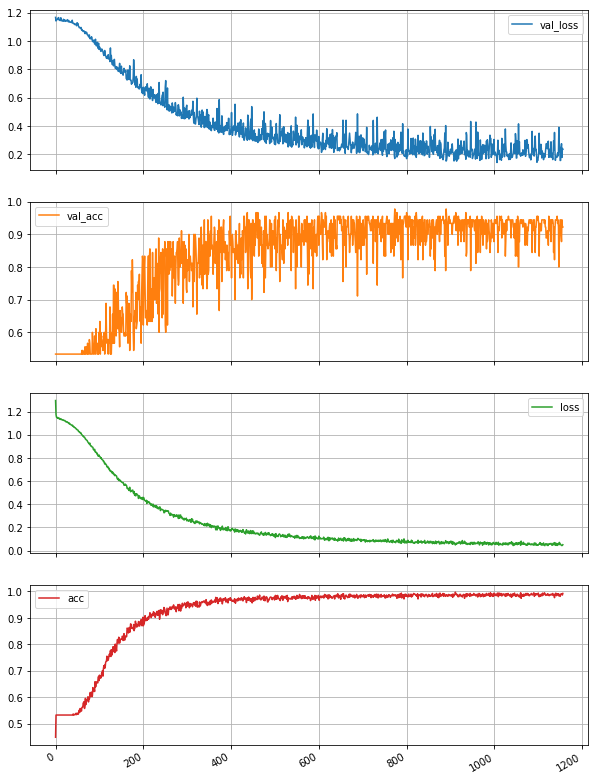

In [10]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

# <font color = blue>Testing Accuracy [Software 2.0]</font>

In [11]:
def decodeLabel(encodedLabel):
    if encodedLabel == 0:
        return "Other"
    elif encodedLabel == 1:
        return "Fizz"
    elif encodedLabel == 2:
        return "Buzz"
    elif encodedLabel == 3:
        return "FizzBuzz"

In [12]:
wrong   = 0
right   = 0
testData = pd.read_csv('testing.csv')
processedTestData  = encodeData(testData['input'].values)
processedTestLabel = encodeLabel(testData['label'].values)
predictedTestLabel = []

for i,j in zip(processedTestData,processedTestLabel):
    
    # Generates output predictions for the input samples.
    y = model.predict(np.array(i).reshape(-1,10))
    
    # regression prediction(argmax) on nparrays of prediction(y)
    predictedTestLabel.append(decodeLabel(y.argmax()))
    
    #compare the true and predicted values
    if j.argmax() == y.argmax():
        right = right + 1
    else:
        wrong = wrong + 1

print("Errors: " + str(wrong), " Correct :" + str(right))

print("Testing Accuracy: " + str(right/(right+wrong)*100))

#UBID and personNumber 
testDataInput = testData['input'].tolist()
testDataLabel = testData['label'].tolist()

testDataInput.insert(0, "UBID")
testDataLabel.insert(0, "saranya")

testDataInput.insert(1, "personNumber")
testDataLabel.insert(1, "50248926")

predictedTestLabel.insert(0, "")
predictedTestLabel.insert(1, "")

output = {}
output["input"] = testDataInput
output["label"] = testDataLabel

output["predicted_label"] = predictedTestLabel

opdf = pd.DataFrame(output)
opdf.to_csv('output.csv')

Errors: 0  Correct :100
Testing Accuracy: 100.0
